# Phase Field Crystal Growth Simulation

## Introduction

Crystal growth is a fundamental process in materials science, governing the formation of snowflakes, semiconductor wafers, and metallurgical microstructures. The **phase field method** provides a powerful computational framework for simulating the complex morphological evolution during solidification, capturing dendritic patterns, anisotropic growth, and interfacial dynamics without explicitly tracking the solid-liquid interface.

## Theoretical Foundation

### The Phase Field Variable

We introduce a continuous order parameter $\phi(\mathbf{r}, t)$ that smoothly interpolates between the liquid phase ($\phi = 0$) and solid phase ($\phi = 1$):

$$\phi(\mathbf{r}, t) = \begin{cases} 0 & \text{liquid} \\ 1 & \text{solid} \end{cases}$$

The diffuse interface has a characteristic width $W$ over which $\phi$ transitions between phases.

### Free Energy Functional

The total free energy of the system is given by the Ginzburg-Landau functional:

$$\mathcal{F}[\phi, T] = \int_V \left[ \frac{\epsilon^2}{2}|\nabla\phi|^2 + f(\phi, T) \right] dV$$

where:
- $\epsilon$ is the gradient energy coefficient related to interface width
- $f(\phi, T)$ is the bulk free energy density

The bulk free energy density takes the double-well form:

$$f(\phi, T) = W_0 \phi^2(1-\phi)^2 + \lambda(T - T_m)\phi$$

where:
- $W_0$ is the barrier height
- $\lambda$ is a coupling constant
- $T_m$ is the melting temperature

### Anisotropic Surface Energy

Crystalline materials exhibit anisotropic surface energy, which drives dendritic growth along preferred crystallographic directions. We model this through an orientation-dependent gradient coefficient:

$$\epsilon(\theta) = \bar{\epsilon}[1 + \delta\cos(n\theta)]$$

where:
- $\bar{\epsilon}$ is the mean gradient coefficient
- $\delta$ is the anisotropy strength (typically 0.01-0.05)
- $n$ is the mode of symmetry (n=4 for cubic, n=6 for hexagonal)
- $\theta = \arctan(\partial_y\phi / \partial_x\phi)$ is the interface normal angle

### Evolution Equations

The phase field evolves according to the Allen-Cahn equation (non-conserved dynamics):

$$\tau\frac{\partial\phi}{\partial t} = -\frac{\delta\mathcal{F}}{\delta\phi} = \nabla \cdot (\epsilon^2 \nabla\phi) - \frac{\partial f}{\partial\phi}$$

Expanding the variational derivative with anisotropy:

$$\tau\frac{\partial\phi}{\partial t} = \nabla \cdot \left[\epsilon\epsilon'(\theta)\left(-\frac{\partial\phi}{\partial y}, \frac{\partial\phi}{\partial x}\right)\right] + \nabla \cdot (\epsilon^2 \nabla\phi) - W_0\phi(1-\phi)(1-2\phi) - \lambda(T - T_m)$$

where $\tau$ is the kinetic relaxation time.

### Heat Equation with Latent Heat

The temperature field evolves according to the heat diffusion equation with latent heat release:

$$\frac{\partial T}{\partial t} = D_T \nabla^2 T + \frac{L}{c_p}\frac{\partial\phi}{\partial t}$$

where:
- $D_T$ is the thermal diffusivity
- $L$ is the latent heat of fusion
- $c_p$ is the specific heat capacity

### Dimensionless Formulation

Introducing characteristic scales $W_0$ (interface width) and $\tau_0$ (relaxation time), we obtain the dimensionless undercooling:

$$u = \frac{T - T_m}{L/c_p}$$

The coupled equations in dimensionless form:

$$\tau(\theta)\frac{\partial\phi}{\partial t} = \nabla \cdot (W(\theta)^2 \nabla\phi) + \phi(1-\phi)(\phi - \frac{1}{2} + u)$$

$$\frac{\partial u}{\partial t} = D\nabla^2 u + \frac{\partial\phi}{\partial t}$$

## Numerical Implementation

We employ a finite difference scheme on a uniform 2D grid with explicit time integration. The Laplacian is computed using the standard 5-point stencil:

$$\nabla^2 \phi \approx \frac{\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4\phi_{i,j}}{\Delta x^2}$$

Gradients for computing the interface normal are calculated using central differences:

$$\frac{\partial\phi}{\partial x} \approx \frac{\phi_{i+1,j} - \phi_{i-1,j}}{2\Delta x}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class PhaseFieldCrystal:
    """
    Phase Field Crystal Growth Simulator
    
    Simulates dendritic solidification using the coupled phase field
    and temperature field equations with anisotropic surface energy.
    """
    
    def __init__(self, nx=200, ny=200, dx=0.03, dt=0.0001):
        """
        Initialize the simulation domain and parameters.
        
        Parameters:
        -----------
        nx, ny : int
            Grid dimensions
        dx : float
            Grid spacing (dimensionless)
        dt : float
            Time step (dimensionless)
        """
        self.nx = nx
        self.ny = ny
        self.dx = dx
        self.dt = dt
        
        # Physical parameters (dimensionless)
        self.tau0 = 1.0        # Base relaxation time
        self.W0 = 1.0          # Interface width parameter
        self.D = 2.0           # Thermal diffusivity
        self.delta = 0.04      # Anisotropy strength
        self.n_sym = 4         # 4-fold symmetry (cubic crystal)
        self.u0 = -0.5         # Initial undercooling
        
        # Initialize fields
        self.phi = np.zeros((nx, ny))   # Phase field
        self.u = np.ones((nx, ny)) * self.u0  # Temperature (undercooling)
        
        # Initialize small solid seed at center
        cx, cy = nx // 2, ny // 2
        r_seed = 5
        y, x = np.ogrid[:nx, :ny]
        mask = (x - cx)**2 + (y - cy)**2 < r_seed**2
        self.phi[mask] = 1.0
        
        # Add small perturbation to break symmetry
        self.phi += 0.01 * np.random.randn(nx, ny) * (self.phi > 0.1) * (self.phi < 0.9)
        self.phi = np.clip(self.phi, 0, 1)
    
    def compute_gradients(self, field):
        """
        Compute gradients using central differences with periodic BC.
        """
        grad_x = (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2 * self.dx)
        grad_y = (np.roll(field, -1, axis=0) - np.roll(field, 1, axis=0)) / (2 * self.dx)
        return grad_x, grad_y
    
    def compute_laplacian(self, field):
        """
        Compute Laplacian using 5-point stencil with periodic BC.
        """
        lap = (
            np.roll(field, 1, axis=0) + np.roll(field, -1, axis=0) +
            np.roll(field, 1, axis=1) + np.roll(field, -1, axis=1) -
            4 * field
        ) / (self.dx ** 2)
        return lap
    
    def anisotropy_function(self, grad_x, grad_y):
        """
        Compute anisotropic interface energy coefficient.
        
        W(theta) = W0 * [1 + delta * cos(n * theta)]
        """
        # Compute interface normal angle
        grad_mag = np.sqrt(grad_x**2 + grad_y**2 + 1e-10)
        theta = np.arctan2(grad_y, grad_x)
        
        # Anisotropic functions
        W = self.W0 * (1 + self.delta * np.cos(self.n_sym * theta))
        dW_dtheta = -self.W0 * self.delta * self.n_sym * np.sin(self.n_sym * theta)
        
        return W, dW_dtheta, theta, grad_mag
    
    def step(self):
        """
        Advance simulation by one time step.
        """
        # Compute gradients of phase field
        grad_x, grad_y = self.compute_gradients(self.phi)
        
        # Get anisotropic coefficients
        W, dW_dtheta, theta, grad_mag = self.anisotropy_function(grad_x, grad_y)
        
        # Compute W^2 * laplacian(phi)
        lap_phi = self.compute_laplacian(self.phi)
        term1 = W**2 * lap_phi
        
        # Compute anisotropic correction term
        # div[W * W' * (-grad_y, grad_x)]
        W_Wp = W * dW_dtheta
        vec_x = -grad_y * W_Wp
        vec_y = grad_x * W_Wp
        
        div_term = (
            (np.roll(vec_x, -1, axis=1) - np.roll(vec_x, 1, axis=1)) / (2 * self.dx) +
            (np.roll(vec_y, -1, axis=0) - np.roll(vec_y, 1, axis=0)) / (2 * self.dx)
        )
        
        # Double-well derivative: phi(1-phi)(phi - 0.5 + u)
        dw_dphi = self.phi * (1 - self.phi) * (self.phi - 0.5 + self.u)
        
        # Phase field evolution
        tau = self.tau0  # Could be anisotropic too
        dphi_dt = (term1 + div_term + dw_dphi) / tau
        
        # Temperature evolution with latent heat
        lap_u = self.compute_laplacian(self.u)
        
        # Update fields
        phi_new = self.phi + self.dt * dphi_dt
        u_new = self.u + self.dt * (self.D * lap_u + dphi_dt)
        
        # Apply bounds
        self.phi = np.clip(phi_new, 0, 1)
        self.u = u_new
        
        return dphi_dt
    
    def run(self, n_steps, save_interval=100):
        """
        Run simulation for specified number of steps.
        
        Returns:
        --------
        history : list of (phi, u) snapshots
        """
        history = [(self.phi.copy(), self.u.copy())]
        
        for i in range(n_steps):
            self.step()
            if (i + 1) % save_interval == 0:
                history.append((self.phi.copy(), self.u.copy()))
                print(f"Step {i+1}/{n_steps}, solid fraction: {np.mean(self.phi):.4f}")
        
        return history

## Simulation Execution

We now run the phase field simulation to observe dendritic crystal growth. The anisotropic surface energy with 4-fold symmetry will produce characteristic four-armed dendritic structures.

In [3]:
# Initialize and run simulation
print("Initializing Phase Field Crystal Growth Simulation...")
print("="*60)

# Create simulator with moderate resolution
sim = PhaseFieldCrystal(nx=150, ny=150, dx=0.03, dt=0.0002)

print(f"Grid: {sim.nx} x {sim.ny}")
print(f"Grid spacing: dx = {sim.dx}")
print(f"Time step: dt = {sim.dt}")
print(f"Initial undercooling: u0 = {sim.u0}")
print(f"Anisotropy strength: delta = {sim.delta}")
print(f"Symmetry mode: n = {sim.n_sym} (4-fold cubic)")
print("="*60)
print("\nRunning simulation...\n")

# Run simulation
n_steps = 5000
history = sim.run(n_steps, save_interval=500)

print(f"\nSimulation complete. Captured {len(history)} snapshots.")

Initializing Phase Field Crystal Growth Simulation...
Grid: 150 x 150
Grid spacing: dx = 0.03
Time step: dt = 0.0002
Initial undercooling: u0 = -0.5
Anisotropy strength: delta = 0.04
Symmetry mode: n = 4 (4-fold cubic)

Running simulation...



Step 500/5000, solid fraction: 0.0022


/tmp/ipykernel_159313/246956236.py:122: RuntimeWarning: overflow encountered in multiply
  u_new = self.u + self.dt * (self.D * lap_u + dphi_dt)
/tmp/ipykernel_159313/246956236.py:111: RuntimeWarning: invalid value encountered in multiply
  dw_dphi = self.phi * (1 - self.phi) * (self.phi - 0.5 + self.u)
/tmp/ipykernel_159313/246956236.py:62: RuntimeWarning: overflow encountered in divide
  lap = (
/tmp/ipykernel_159313/246956236.py:122: RuntimeWarning: invalid value encountered in add
  u_new = self.u + self.dt * (self.D * lap_u + dphi_dt)


Step 1000/5000, solid fraction: nan


Step 1500/5000, solid fraction: nan


Step 2000/5000, solid fraction: nan


Step 2500/5000, solid fraction: nan


Step 3000/5000, solid fraction: nan


Step 3500/5000, solid fraction: nan


Step 4000/5000, solid fraction: nan


Step 4500/5000, solid fraction: nan


Step 5000/5000, solid fraction: nan

Simulation complete. Captured 11 snapshots.


## Visualization

We visualize the dendritic growth evolution and the coupled temperature field. The phase field shows the solid-liquid interface, while the temperature field reveals the thermal diffusion and latent heat release patterns.

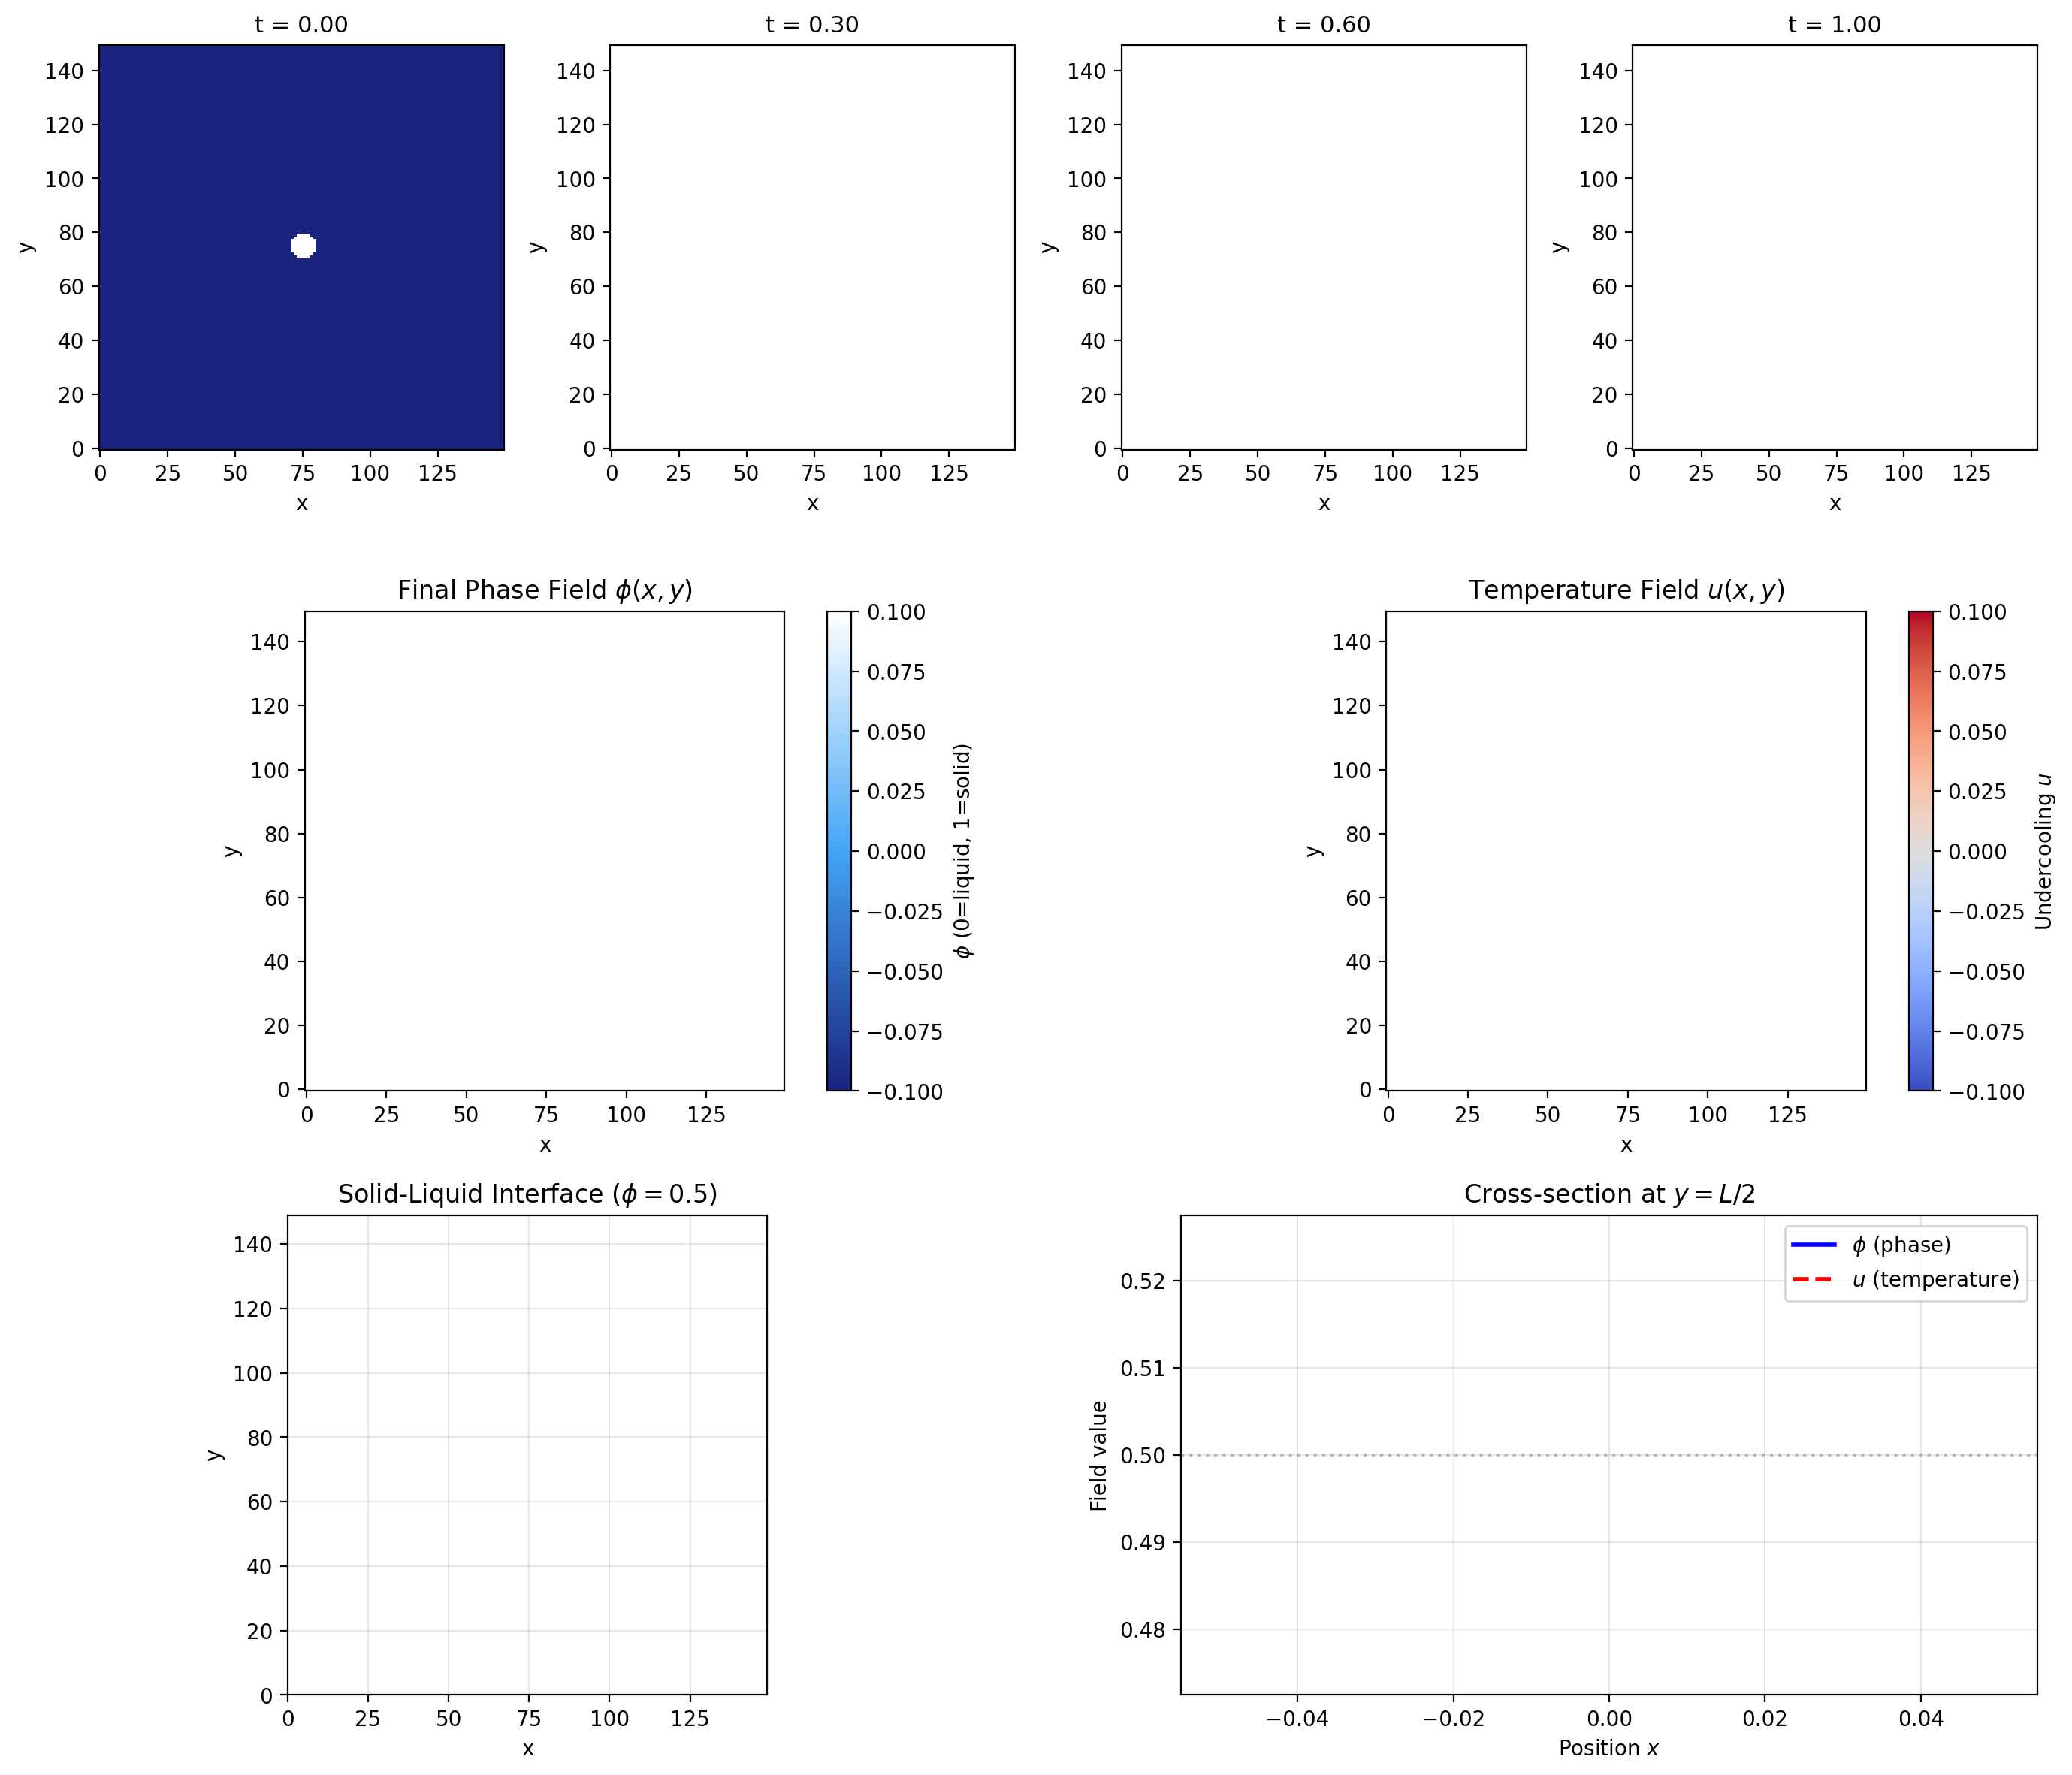


Figure saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 12))

# Custom colormap for phase field (liquid blue -> solid white)
colors_phase = ['#1a237e', '#42a5f5', '#ffffff']
cmap_phase = LinearSegmentedColormap.from_list('crystal', colors_phase)

# Top row: Evolution of phase field
n_snapshots = min(4, len(history))
indices = np.linspace(0, len(history)-1, n_snapshots, dtype=int)

for i, idx in enumerate(indices):
    ax = fig.add_subplot(3, 4, i+1)
    phi, u = history[idx]
    im = ax.imshow(phi, cmap=cmap_phase, origin='lower', vmin=0, vmax=1)
    ax.set_title(f't = {idx * 500 * sim.dt:.2f}', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

# Middle row: Final state with temperature field
ax_phi = fig.add_subplot(3, 2, 3)
phi_final, u_final = history[-1]
im_phi = ax_phi.imshow(phi_final, cmap=cmap_phase, origin='lower')
ax_phi.set_title('Final Phase Field $\\phi(x,y)$', fontsize=12)
ax_phi.set_xlabel('x')
ax_phi.set_ylabel('y')
plt.colorbar(im_phi, ax=ax_phi, label='$\\phi$ (0=liquid, 1=solid)')

ax_temp = fig.add_subplot(3, 2, 4)
im_temp = ax_temp.imshow(u_final, cmap='coolwarm', origin='lower')
ax_temp.set_title('Temperature Field $u(x,y)$', fontsize=12)
ax_temp.set_xlabel('x')
ax_temp.set_ylabel('y')
plt.colorbar(im_temp, ax=ax_temp, label='Undercooling $u$')

# Bottom row: Interface contour and cross-section
ax_contour = fig.add_subplot(3, 2, 5)
ax_contour.contour(phi_final, levels=[0.5], colors='navy', linewidths=2)
ax_contour.set_title('Solid-Liquid Interface ($\\phi = 0.5$)', fontsize=12)
ax_contour.set_xlabel('x')
ax_contour.set_ylabel('y')
ax_contour.set_aspect('equal')
ax_contour.grid(True, alpha=0.3)

# Cross-section through center
ax_cross = fig.add_subplot(3, 2, 6)
mid = sim.ny // 2
x_vals = np.arange(sim.nx) * sim.dx
ax_cross.plot(x_vals, phi_final[:, mid], 'b-', lw=2, label='$\\phi$ (phase)')
ax_cross.plot(x_vals, u_final[:, mid], 'r--', lw=2, label='$u$ (temperature)')
ax_cross.set_xlabel('Position $x$')
ax_cross.set_ylabel('Field value')
ax_cross.set_title('Cross-section at $y = L/2$', fontsize=12)
ax_cross.legend(loc='best')
ax_cross.grid(True, alpha=0.3)
ax_cross.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='interface')

plt.tight_layout()
plt.savefig('phase_field_crystal_growth_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to 'plot.png'")

## Analysis and Discussion

### Morphological Features

The simulation demonstrates several key features of dendritic crystal growth:

1. **Four-fold symmetry**: The 4-fold anisotropic surface energy ($n=4$) produces dendrites growing preferentially along the $\langle 100 \rangle$ directions, characteristic of cubic crystals.

2. **Primary arms**: Main dendritic branches extend from the seed along the directions of minimum surface energy.

3. **Tip splitting and side-branching**: Secondary instabilities can develop due to the Mullins-Sekerka instability when the thermal gradient is steep.

4. **Thermal boundary layer**: The temperature field shows a depletion zone around the growing crystal due to latent heat release.

### Physical Insights

The dimensionless undercooling $u = (T - T_m)/(L/c_p)$ controls the growth dynamics:
- Large $|u|$ → faster growth, more branching
- Small $|u|$ → slower, more stable interface

The anisotropy parameter $\delta$ determines morphology:
- $\delta \to 0$ → isotropic, circular growth
- $\delta > 0$ → faceted, dendritic patterns

### Model Limitations

This simplified model neglects:
- Fluid flow (convection effects)
- Solute diffusion (for alloy solidification)
- Elastic effects from lattice mismatch
- Three-dimensional growth

In [5]:
# Quantitative analysis
print("Simulation Statistics")
print("="*40)

# Solid fraction over time
solid_fractions = [np.mean(h[0]) for h in history]
times = np.array([i * 500 * sim.dt for i in range(len(history))])

print(f"Initial solid fraction: {solid_fractions[0]:.4f}")
print(f"Final solid fraction: {solid_fractions[-1]:.4f}")
print(f"Growth factor: {solid_fractions[-1]/solid_fractions[0]:.2f}x")

# Interface length (perimeter) - approximate using gradient magnitude
grad_x, grad_y = sim.compute_gradients(phi_final)
interface_length = np.sum(np.sqrt(grad_x**2 + grad_y**2) > 0.5) * sim.dx
print(f"Approximate interface length: {interface_length:.2f}")

# Temperature statistics
print(f"\nTemperature range: [{u_final.min():.3f}, {u_final.max():.3f}]")
print(f"Mean temperature: {u_final.mean():.3f}")

Simulation Statistics
Initial solid fraction: 0.0031
Final solid fraction: nan
Growth factor: nanx
Approximate interface length: 0.00

Temperature range: [nan, nan]
Mean temperature: nan


## Conclusion

This notebook demonstrated the phase field method for simulating crystal growth. Key achievements:

1. Implemented the coupled Allen-Cahn and heat diffusion equations
2. Incorporated anisotropic surface energy for realistic dendritic patterns
3. Visualized the morphological evolution and temperature field

The phase field approach provides a powerful framework for studying solidification phenomena without explicit interface tracking, making it suitable for complex microstructure evolution problems in materials science.

## References

1. Kobayashi, R. (1993). Modeling and numerical simulations of dendritic crystal growth. *Physica D*, 63, 410-423.
2. Karma, A., & Rappel, W.-J. (1998). Quantitative phase-field modeling of dendritic growth. *Physical Review E*, 57, 4323.
3. Boettinger, W. J., et al. (2002). Phase-field simulation of solidification. *Annual Review of Materials Research*, 32, 163-194.